In [139]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

### Parameters inicialization, ULA algorithm

In [140]:
d = 2
a = np.ones((d,1)) / np.sqrt(2*d)

def f_grad(x):
    return x-a+2*a/(1 + np.exp(2* (x.T @ a)))

def generate_lmc(a,d,N):
    h = 0.1
    K = 10000
    vkh = np.empty((K + N,d,1))
    ksi = np.random.randn(K+N,d,1)
    vkh[0] = (np.random.normal(0,1,d)).reshape(d,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh[K:], ksi[K:]

### Sample generation

In [141]:
np.random.seed(2342)
X, Z = generate_lmc(a,d, 1000000)

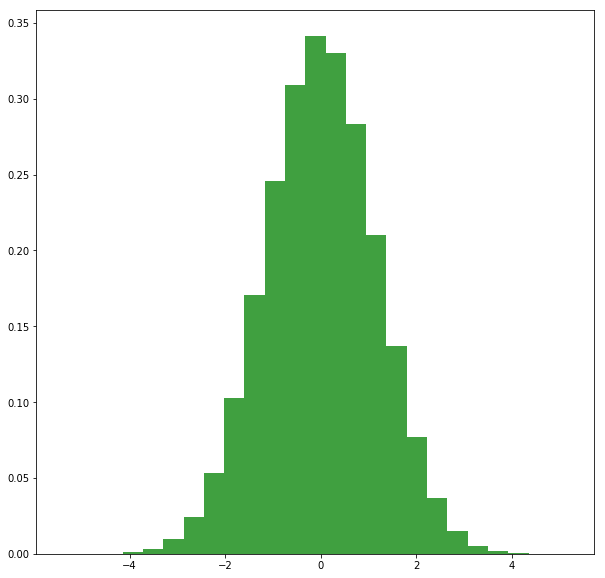

In [142]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 25, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.show()

In [143]:
def local_weighted_estimator(X):
    return X[:,0].mean() + X[:,1].mean()

In [144]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.00790899409333417


### Generation of N_train independent paths

In [195]:
def generate_lmc_from_initial(x_initial,a,d,N):
    h = 0.1
    vkh = np.empty((N,d,1))
    vkh_grad = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1])
        vkh_grad[i-1] = grad
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    vkh_grad[-1] = f_grad(vkh[-1])
    return vkh, ksi, vkh_grad


def generate_paths(x_initial,N_train,a,d,N):
    XX = []
    ZZ = []
    GG = []
    for i in range(N_train):
        X, Z, G = generate_lmc_from_initial(x_initial[-i],a,d,N)
        XX.append(X)
        ZZ.append(Z)
        GG.append(G)
    return np.array(XX),np.array(ZZ), np.array(GG)

In [146]:
np.random.seed(123)
XX, ZZ, _= generate_paths(X,1000,a,d,1000)

In [147]:
XX.shape

(1000, 1000, 2, 1)

### Generate validation path

In [10]:
np.random.seed(42)
X_validate, Z_validate = generate_lmc_from_initial(X[-5000],a,d,1000)

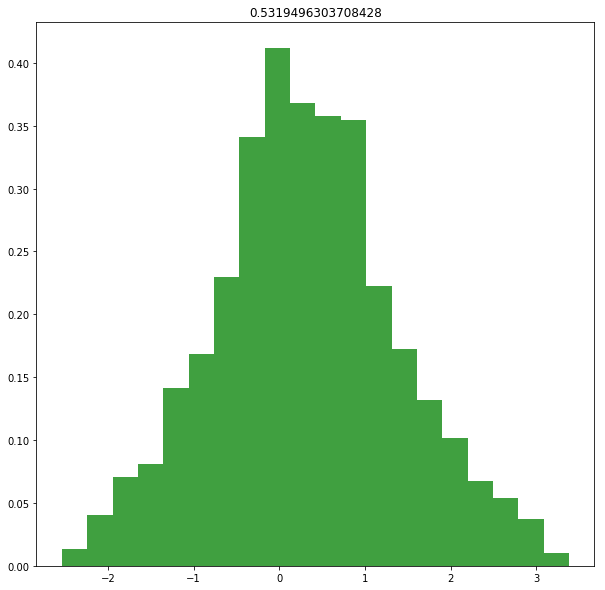

In [11]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X_validate[:,1].reshape(-1,1), 20, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.title((local_weighted_estimator(X_validate)))
plt.show()

### (normalized) Hermite polynomials

In [163]:
from itertools import repeat
def generate_k_vec(d, K):
    r = list(range(K+1))
    k = []
    for roll in product(r, repeat = d):
        k.append(list(roll))
    k.sort(key=lambda t:sum(t)+max(t)-min(t))
    k.remove(list(repeat(0,d)))
    k.remove([2,2])
    k.remove([1,2])
    k.remove([2,1])
    return k
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

In [164]:
k_comb = generate_k_vec(d,2)
k_comb

[[0, 1], [1, 0], [1, 1], [0, 2], [2, 0]]

In [167]:
deg_pol = 6
def pol_ar_1d(x): #x.shape = (2,1)
    return np.array([1,x[0],x[1],x[0]*x[1],x[0]**2,x[1]**2])#,x[0]**2 *x[1],x[0]* x[1]**2, x[0]**3, x[1]**3])

def generate_X(XX, l):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    X = np.empty((N_train, deg_pol))
    X[:,0] = np.ones(N_train)
    X[:,1] = XX[:,l,0].squeeze()
    X[:,2] = XX[:,l,1].squeeze()
    X[:,3] = (XX[:,l,0] * XX[:,l,1]).squeeze()
    X[:,4] = (XX[:,l,0]**2).squeeze()
    X[:,5] = (XX[:,l,1]**2).squeeze()
#     X[:,6] = (XX[:,l,0]**2 * XX[:,l,1]).squeeze()
#     X[:,7] = (XX[:,l,0] * XX[:,l,1]**2).squeeze()
#     X[:,8] = (XX[:,l,0]**3).squeeze()
#     X[:,9] = (XX[:,l,1]**3).squeeze()
    return X 



def generate_y(XX,ZZ,l,n_tilde = 60):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    y = np.zeros(N_train)
    for s in range(N_train):
        y[s] = XX[s][l:l+n_tilde].sum()
    return y

def q_l_fit(XX,ZZ):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    Betas = np.zeros((N,deg_pol))
    for l in tqdm(range (N)):
        X = generate_X(XX,l)
        y = generate_y(XX,ZZ,l)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[l] = beta
    return Betas

def q_l_predict(x,l, Betas,k):
    x_pol = pol_ar_1d(x)
    beta = Betas[l]
    return (x_pol @ beta)

In [168]:
Betas = q_l_fit(XX,ZZ)

100%|██████████| 1000/1000 [00:03<00:00, 312.19it/s]


In [169]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

l = 100
# Make data.
X_plot = np.linspace(generate_X(XX,l)[:,1].min(), generate_X(XX,l)[:,1].max(),num = 50)
Y_plot = np.linspace(generate_X(XX,l)[:,2].min(), generate_X(XX,l)[:,2].max(),num = 50)
X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
Z_plot_real = X_plot + Y_plot

Z_plot = np.empty((X_plot.shape[0],X_plot.shape[0]))
for i in range(X_plot.shape[0]):
    XY_plot = np.hstack((X_plot[i].reshape(-1,1,1), Y_plot[i].reshape(-1,1,1)))
    for j in range(X_plot.shape[0]):
        Z_plot[i,j] = q_l_predict(XY_plot[j],l,Betas, 0)
        
predict_plot = go.Surface(x = X_plot, y = Y_plot,z=Z_plot)
real_scatter = go.Scatter3d(
    x=generate_X(XX,l)[:,1],
    y=generate_X(XX,l)[:,2],
    z=generate_y(XX,ZZ,l),
    mode='markers',
    marker=dict(
        size=5,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)       
        
data = [predict_plot, real_scatter]
# plotly.offline.plot(data, filename="surface_Q_l={}".format(l))
plotly.offline.plot(data)

'file:///home/ubuntu/Paper_Belomestny/algo_2/temp-plot.html'

In [170]:
# degrees = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2],[2,1],[1,2],[3,0],[0,3]])
# degrees = np.array([[0,0],[1,0],[0,1],[1,1]])
degrees = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2]])

In [171]:
def a_lk(X,l,k_vec, Betas):
    d = 2
    h = 0.1
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1])
    Small_s = np.zeros(d)
    for ind,deg in enumerate(degrees):
        Small_s[:] = 0
        for d, i in enumerate(deg):
            for t in range (i+1):
                for s in range (int(t/2 +1)):
                    if (k_vec[d] == t - 2*s):
                        Small_s[d] = Small_s[d] + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                        math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                    else:
                        pass
        S = S + Betas[l,ind] * Small_s.prod()
    return S

def M_bias(k_vec,X,Z, Betas):
    N = X.shape[0]
    S = 0
    for l in range (N):
        s = a_lk(X,l,k_vec, Betas)* Hermite_val(k_vec,Z[l])
        S = S + s
    return S/N

def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas)for i in range(first, last))
    return np.array(M_results).reshape(-1)

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

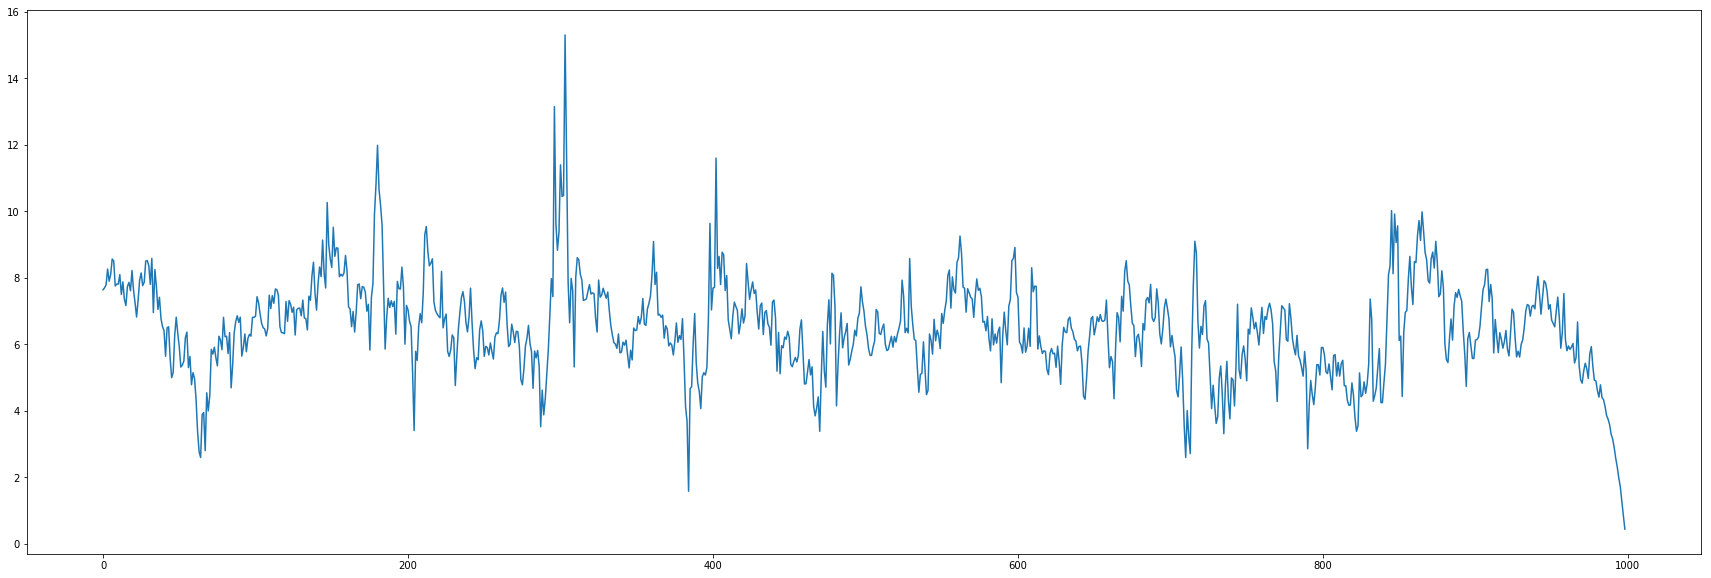

In [172]:
plot_a_lk = []
for i in range (1,XX.shape[1]):
    plot_a_lk.append(a_lk(XX[0],i,k_comb[0], Betas))
plot_a_lk = np.array(plot_a_lk)
plt.figure(figsize=(30,10))
plt.plot(plot_a_lk)

### check formula ( full)

In [173]:
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X_validate))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X_validate,Z_validate,Betas),
                                           timeit.default_timer()-time_1))

P = 0.5319496303708428
M ([0, 1]) = [0.33784921] [Time:0.6942067939962726]
M ([1, 0]) = [0.21752497] [Time:1.3770026059937663]
M ([1, 1]) = [0.00281969] [Time:2.0225223949964857]
M ([0, 2]) = [-0.00913113] [Time:2.639693773991894]
M ([2, 0]) = [0.0131085] [Time:3.2848625979968347]


In [174]:
X = XX[27]
Z = ZZ[27]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas),timeit.default_timer()-time_1))

P = 0.277636103873029
M ([0, 1]) = [0.16115092] [Time:0.6858734009874752]
M ([1, 0]) = [0.10749211] [Time:1.3426211459882325]
M ([1, 1]) = [-0.0265797] [Time:1.9241179369855672]
M ([0, 2]) = [0.00897157] [Time:2.574666382992291]
M ([2, 0]) = [-0.00797937] [Time:3.2095119489968056]


## Check on test sample

In [196]:
np.random.seed(987)
X, Z = generate_lmc(a,d,100000)
XX_test, ZZ_test, GG_test = generate_paths(X,200,a,d,1000)
P_test = estimator(XX_test)

100%|██████████| 200/200 [00:00<00:00, 55938.97it/s]


In [197]:
print ('Variance of Pi = ',P_test.var(dtype=np.float64,ddof = 1))

Variance of Pi =  0.09296435370053532


In [177]:
M_results_algo_2 = np.empty((len(k_comb), XX_test.shape[0]))

for i,k in enumerate(k_comb):
    M_results_algo_2[i] = estimator_bias(k,XX_test,ZZ_test,Betas, 0, 200)

In [179]:
M_results_algo_1 = np.load('../VR-MCMC/Gaussian_mixture_2d_reduced_truncated/GM(2d)_M_results_test.npy')

In [218]:
print ('Variance of Pi = ',(P_test - M_results_algo_1.sum(axis = 0)).var(ddof = 1))
print ('Variance of Pi = ',(P_test - M_results_algo_1[:3].sum(axis = 0)).var(ddof = 1))
print ('Variance of Pi = ',(P_test - M_results_algo_2.sum(axis = 0)).var(ddof = 1))
print ('Variance of Pi = ',(P_test - M_results_algo_2[:3].sum(axis = 0)).var(ddof = 1))

Variance of Pi =  0.00085208405156503
Variance of Pi =  0.000868034848178172
Variance of Pi =  0.003982653841986601
Variance of Pi =  0.003753718582081946


In [219]:
print ('c = ',P_test.var(dtype=np.float64,ddof = 1) / (P_test - M_results_algo_1.sum(axis = 0)).var(ddof = 1))
print ('c = ',P_test.var(dtype=np.float64,ddof = 1) / (P_test - M_results_algo_2.sum(axis = 0)).var(ddof = 1))
print ('c = ',P_test.var(dtype=np.float64,ddof = 1) / (P_test - M_results_algo_1[:3].sum(axis = 0)).var(ddof = 1))
print ('c = ',P_test.var(dtype=np.float64,ddof = 1) / (P_test - M_results_algo_2[:3].sum(axis = 0)).var(ddof = 1))

c =  109.10232802713172
c =  23.34231328881032
c =  107.09749026280285
c =  24.765935876038416


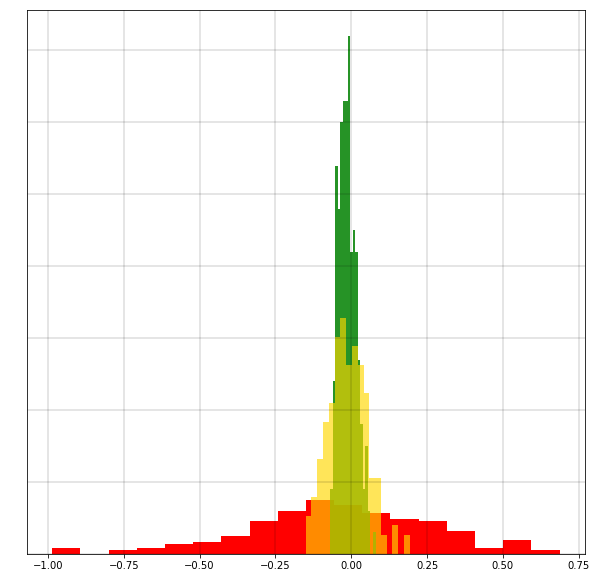

In [181]:
plt.figure(figsize=(10,10))
plt.hist(P_test.reshape(-1,1),18, facecolor='r', density=True,
                            alpha=1, label="Distribution of $\pi$")

plt.hist((P_test-M_results_algo_1.sum(axis = 0)).reshape(-1,1), 18, density=True, facecolor='g', 
                            alpha=0.85, label="Distribution of $\pi - M^1_N$")

plt.hist((P_test-M_results_algo_2.sum(axis = 0)).reshape(-1,1), 18, density=True, facecolor='gold', 
                            alpha=0.65, label="Distribution of $\pi - M^1_N$")
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
plt.show()

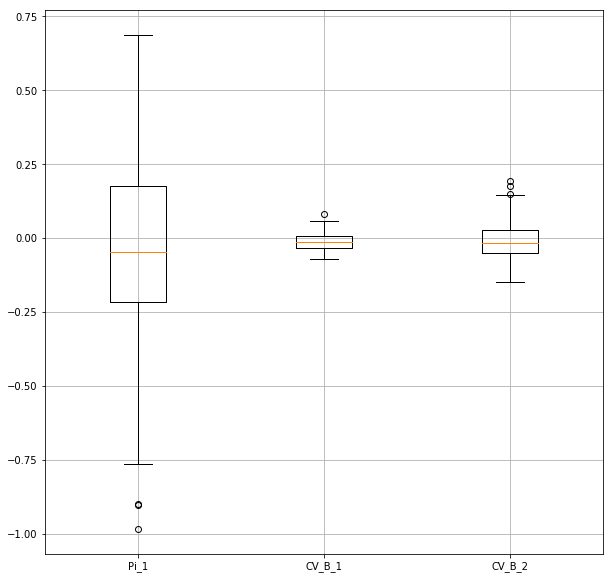

In [216]:
plt.figure(figsize=(10,10))

# generate some random test data
all_data = [P_test, 
            P_test - M_results_algo_1.sum(axis = 0),
            P_test - M_results_algo_2.sum(axis = 0)]

# plot violin plot
plt.boxplot(all_data)
plt.xticks(np.arange(1,4), ('Pi_1', 'CV_B_1','CV_B_2'))
plt.grid()
plt.show()

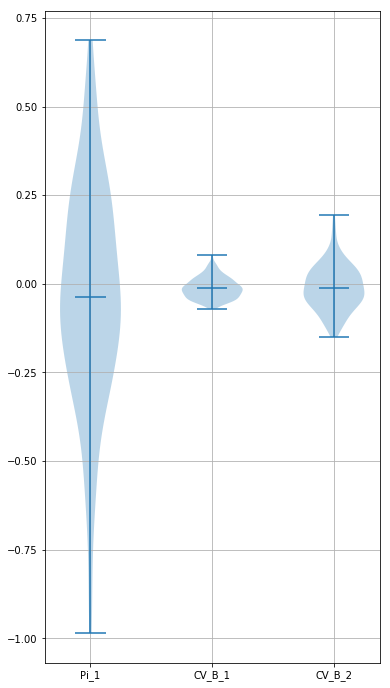

In [217]:
plt.figure(figsize=(6,12))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,4), ('Pi_1', 'CV_B_1','CV_B_2'))
plt.grid()
plt.show()

In [211]:
def ZVpolyOne(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    cov1 = np.cov(traj_grad, rowvar=False)
    A = np.linalg.inv(cov1)
    covariance = np.cov(np.concatenate((-traj_grad, samples), axis=1), rowvar=False)
    paramZV1 = -np.dot(A,covariance[:d, d:])
    ZV1 = samples - np.dot(traj_grad, paramZV1)
    mean_ZV1 = np.mean(ZV1, axis = 0)
    return mean_ZV1

def ZVpolyTwo(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    Lpoisson = np.zeros((n,int(d*(d+3)/2)))
    Lpoisson[:,np.arange(d)] = - traj_grad
    Lpoisson[:,np.arange(d, 2*d)] = 2*(1. - np.multiply(traj, traj_grad))
    k=2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            Lpoisson[:,k] = -np.multiply(traj_grad[:,i], traj[:,j])-np.multiply(traj_grad[:,j], traj[:,i])
            k=k+1
    
    cov1 = np.cov(Lpoisson, rowvar=False)
    A = np.linalg.inv(cov1)
    cov2 = np.cov(np.concatenate((Lpoisson, samples),axis=1), rowvar=False)
    B = cov2[0:int(d*(d+3)/2), int(d*(d+3)/2):]
    paramZV2 = - np.dot(A,B)
    ZV2 = samples + np.dot(Lpoisson, paramZV2)
    mean_ZV2 = np.mean(ZV2, axis = 0)
    return mean_ZV2

def CVpolyOne(traj,traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    covariance = np.cov(np.concatenate((traj, samples), axis=1), rowvar=False)
    paramCV1 = covariance[:d, d:]
    CV1 = samples - np.dot(traj_grad, paramCV1)
    mean_CV1 = np.mean(CV1, axis = 0)
    return mean_CV1

def CVpolyTwo(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    poisson = np.zeros((n,int(d*(d+3)/2)))
    poisson[:,np.arange(d)] = traj
    poisson[:,np.arange(d, 2*d)] = np.multiply(traj, traj)
    k = 2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            poisson[:,k] = np.multiply(traj[:,i], traj[:,j])
            k=k+1
    Lpoisson = np.zeros((n,int(d*(d+3)/2)))
    Lpoisson[:,np.arange(d)] = - traj_grad
    Lpoisson[:,np.arange(d, 2*d)] = 2*(1. - np.multiply(traj, traj_grad))
    k=2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            Lpoisson[:,k] = -np.multiply(traj_grad[:,i], traj[:,j]) \
                    -np.multiply(traj_grad[:,j], traj[:,i])
            k=k+1
    
    cov1 = np.cov(np.concatenate((poisson, -Lpoisson), axis=1), rowvar=False)
    A = np.linalg.inv(cov1[0:int(d*(d+3)/2), int(d*(d+3)/2):d*(d+3)])
    cov2 = np.cov(np.concatenate((poisson, samples),axis=1), rowvar=False)
    B = cov2[0:int(d*(d+3)/2), int(d*(d+3)/2):]
    paramCV2 = np.dot(A,B)
    CV2 = samples + np.dot(Lpoisson, paramCV2)
    mean_CV2 = np.mean(CV2, axis = 0)
    return mean_CV2

In [212]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVpolyOne(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVpolyTwo(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(CVpolyOne(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(CVpolyTwo(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_cv_2 = np.array(res_cv_2).reshape(-1)

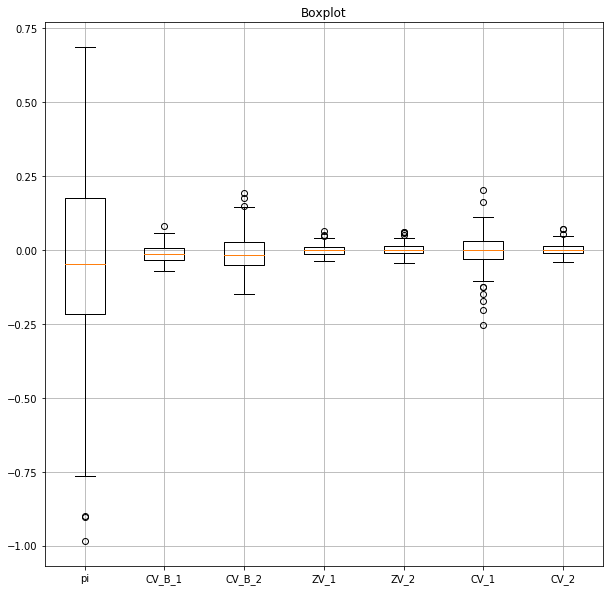

In [213]:
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2) 

plt.figure(figsize=(10,10))
plt.boxplot(all_data)
plt.xticks(np.arange(1,8), ('pi', 'CV_B_1','CV_B_2', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.title('Boxplot')
plt.grid()
plt.show()

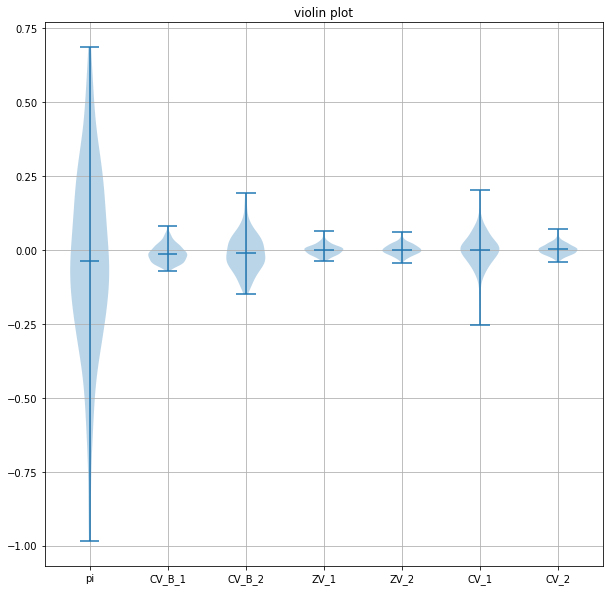

In [214]:
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,8), ('pi', 'CV_B_1','CV_B_2', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()